## This is just a simple Notebook to analyse the results of the "count_lines_with_dillution"-method in "img_preprocessing"

****

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("line_detection_results_all_images.csv")
df.head()

,image_name,dilution,number_of_lines
0,bsb00050531.0011.jpeg,20,850
1,bsb00050531.0011.jpeg,25,695
2,bsb00050531.0011.jpeg,30,587
3,bsb00050531.0011.jpeg,35,492
4,bsb00050531.0011.jpeg,40,420


In [7]:
unique_image_names = df["image_name"].nunique()
print(f"Number of unique entries in 'image_name': {unique_image_names}")

Number of unique entries in 'image_name': 3


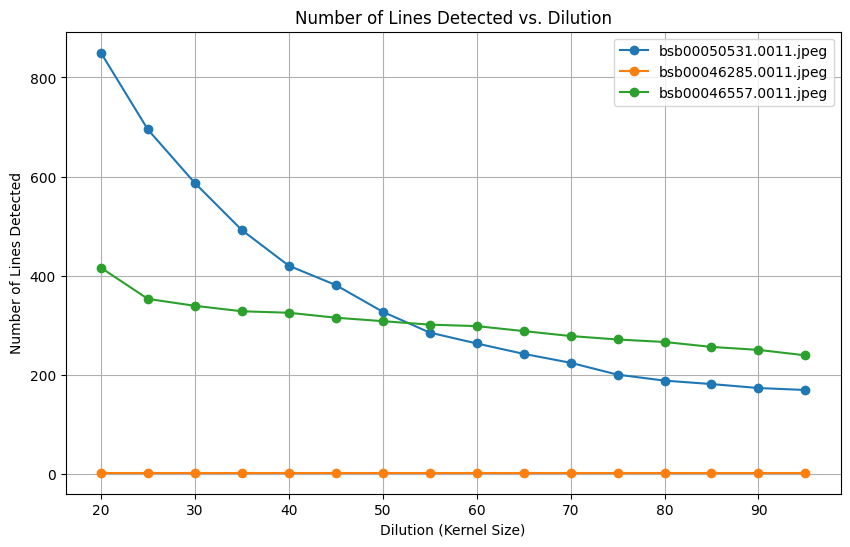

In [8]:
# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
for image_name in df["image_name"].unique():
    image_df = df[df["image_name"] == image_name]
    plt.plot(
        image_df["dilution"],
        image_df["number_of_lines"],
        label=image_name,
        marker="o",
    )

plt.title("Number of Lines Detected vs. Dilution")
plt.xlabel("Dilution (Kernel Size)")
plt.ylabel("Number of Lines Detected")
plt.legend()
plt.grid(True)
plt.show()